<h1><font color="#113D68" size=6>Deep Learning con Python y Keras</font></h1>

<h1><font color="#113D68" size=5>Parte 6. Redes Neuronales Recurrentes</font></h1>

<h1><font color="#113D68" size=4>2. Series de Tiempo con MLP</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. Predicción en series temporales](#section1)
* [2. MLP para regresión](#section2)
    * [2.1. Cargar el dataset](#section2.1)
    * [2.2. Entretamiento](#section2.2)
    * [2.3. Predicción en Y](#section2.3)
    * [2.4. Desarrollo MLP](#section2.4)
    * [2.5. Estimar el rendimiento del modelo](#section2.5)
    * [2.6. Predicciones del modelo](#section2.6)
* [3. MLP mediante el método de ventana](#section3)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

En esta lección, aprenderesmo a desarrollar modelos de redes neuronales para la predicción de series de tiempo:
* Predicción de series de tiempo en un ejemplo práctico.
* Desarrollar un modelo de red neuronal para Series temporales.
* Desarrollar un modelo de red neuronal para Series de tiempo con desfase.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Predicción en series temporales</font>

El problema que veremos es un problema de predicción de pasajeros de aerolíneas internacionales. Este es un problema en el que, dado un año y un mes, la tarea es predecir el número de pasajeros de aerolíneas internacionales en unidades de 1.000. Los datos van desde enero de 1949 hasta diciembre de 1960 o 12 años, con 144 observaciones. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre el dataset [Air Passengers](https://www.kaggle.com/chirag19/air-passengers)

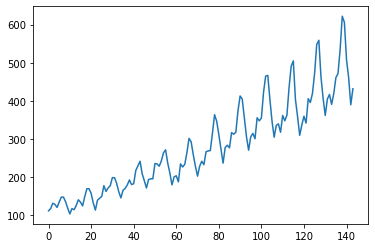

In [1]:
# Declare libraries and dataset
import pandas as pd
import matplotlib.pyplot as plt

r = "C:/Users/Maria Luisa/OneDrive/Documentos/Cursos/DeepLearningConPythonyKerasRedesNeuronalesAvanzado/SeriesTemporalesconANN/data/international-airline-passengers.csv"
dataset = pd.read_csv(r , usecols =[1], engine = 'python' )

#print(dataset.head(5))
plt.plot(dataset)
plt.show()


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. MLP para regresión</font>

Podemos escribir una función simple para convertir nuestra única columna de datos en un conjunto de datos de dos columnas. La primera columna contiene el recuento de pasajeros $(t)$ de este mes y la segunda columna contiene el recuento de pasajeros $(t + 1)$ del próximo mes (por predecir). 

<a id="section2.1"></a>
# <font color="#004D7F" size=5>2.1. Cargar el dataset</font>

Antes de comenzar, primero importemos todas las funciones y clases que pretendemos usar.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense

# load the dataset
r = "C:/Users/Maria Luisa/OneDrive/Documentos/Cursos/DeepLearningConPythonyKerasRedesNeuronalesAvanzado/SeriesTemporalesconANN/data/international-airline-passengers.csv"
dataframe = pd.read_csv(r , usecols =[1], engine = 'python' )
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

<a id="section2.2"></a>
# <font color="#004D7F" size=5>2.2. Entretamiento</font>

Con datos de series de tiempo, la secuencia de valores es importante. Un método simple para entrenamiento es dividir el conjunto de datos ordenado en conjuntos de datos de prueba/validación. En este caso vamos a modelarlo en 67% para prueba y 33% para validación.

In [2]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_set = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

<a id="section2.3"></a>
# <font color="#004D7F" size=5>2.3. Predicción en $Y$</font>

Ahora podemos definir una función para crear un nuevo conjunto de datos como se describe arriba. 
La función toma dos argumentos:
* El **conjunto de datos,** que es una matriz NumPy y
* La **"vista hacia atrás"**: que es el número de pasos de tiempo anteriores, predeterminado a 1. 
    * Este valor predeterminado creará un conjunto de datos donde $X$ es el número de pasajeros en un momento dado $(t)$ e $Y$ es el número de pasajeros en el siguiente momento $(t + 1)$. 

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, loock_back=1):
    dataX, dataY = [] , []
    for i in range(len(dataset) - look_back -1):
        a = dataset[i : (i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Si nos fijamos podemos observar el patrón $X = t$ y $Y = t + 1$ en los números. 
```
   X1  Y  
   112 118
   118 132
   132 129
   129 121
   121 135 
```

In [18]:
# reshape into X=t and Y=t+1
llok_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, loo )

[112.] 118.0
[118.] 132.0
[132.] 129.0
[129.] 121.0
[121.] 135.0


<a id="section2.4"></a>
# <font color="#004D7F" size=5>2.4. Desarrollo MLP</font>

Usamos una red simple:
1. con 1 entrada.
2. 1 capa oculta con 8 neuronas y 
3. 1 capa de salida.
4. El modelo se ajusta usando el error cuadrático medio

In [19]:
# create and fit Multilayer Perceptron model
???


Epoch 1/200
47/47 - 0s - loss: 62802.1211
Epoch 2/200
47/47 - 0s - loss: 55678.8672
Epoch 3/200
47/47 - 0s - loss: 49357.7305
Epoch 4/200
47/47 - 0s - loss: 44496.1875
Epoch 5/200
47/47 - 0s - loss: 40556.7539
Epoch 6/200
47/47 - 0s - loss: 36343.2461
Epoch 7/200
47/47 - 0s - loss: 32069.5215
Epoch 8/200
47/47 - 0s - loss: 27707.7520
Epoch 9/200
47/47 - 0s - loss: 23447.3027
Epoch 10/200
47/47 - 0s - loss: 19310.0977
Epoch 11/200
47/47 - 0s - loss: 15526.8057
Epoch 12/200
47/47 - 0s - loss: 12113.6768
Epoch 13/200
47/47 - 0s - loss: 9182.5762
Epoch 14/200
47/47 - 0s - loss: 6787.7168
Epoch 15/200
47/47 - 0s - loss: 4854.5859
Epoch 16/200
47/47 - 0s - loss: 3410.1748
Epoch 17/200
47/47 - 0s - loss: 2361.8379
Epoch 18/200
47/47 - 0s - loss: 1662.5183
Epoch 19/200
47/47 - 0s - loss: 1181.5688
Epoch 20/200
47/47 - 0s - loss: 897.1627
Epoch 21/200
47/47 - 0s - loss: 727.7666
Epoch 22/200
47/47 - 0s - loss: 632.7629
Epoch 23/200
47/47 - 0s - loss: 585.0093
Epoch 24/200
47/47 - 0s - loss: 557

Epoch 198/200
47/47 - 0s - loss: 533.5473
Epoch 199/200
47/47 - 0s - loss: 540.7738
Epoch 200/200
47/47 - 0s - loss: 535.5789


<a id="section2.5"></a>
# <font color="#004D7F" size=5>2.5. Estimar el rendimiento del modelo</font>

Una vez que el modelo se ajusta, podemos estimar el rendimiento del modelo en el train/test.

In [20]:
# Estimate model performance
???

Train Score: 530.57 MSE (23.03 RMSE)
Test Score: 2351.26 MSE (48.49 RMSE)


<a id="section2.6"></a>
# <font color="#004D7F" size=5>2.6. Predicciones del modelo</font>

Finalmente, podemos generar predicciones. Los datos se grafican, mostrando el conjunto de datos original en azul, las predicciones de train en verde y las predicciones de test en rojo.

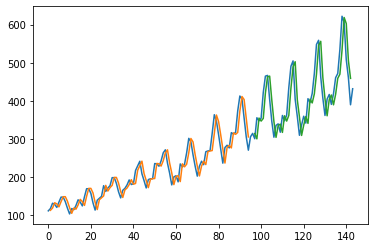

In [22]:
# generate predictions for training
???

# shift train predictions for plotting
???

# shift test predictions for plotting
???

# plot baseline and predictions
???


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. MLP mediante el método de ventana</font>

Hacer la predicción para el próximo paso de tiempo se denomina método de ventana y el tamaño de la ventana es un parámetro que se puede ajustar. 

Por ejemplo, dado el tiempo actual $(t)$ que queremos predecir el valor en el próximo tiempo en la secuencia $(t + 1)$, podemos usar el tiempo actual $(t)$ así como los dos tiempos anteriores ($t-1$ y $t-2$). Por tanto: 
* Las variables de entrada son $t-2$, $t-1$, $t$ y 
* La variable de salida es $t + 1$.
Nuestro problema quedaría como:
```
   X1  X2  X3  Y
   112 118 132 129
   118 132 129 121
   132 129 121 135
   129 121 135 148
   121 135 148 148 
```

La función `create_dataset()` permite crear el tamaño de ventana con el argumento `look_back` de 1 a 3.

Agrandamos nuestra arquitectura:
* La primera capa oculta se aumenta a 14 neuronas
* Agregamos una segunda capa oculta con 8 neuronas. 
* El número de épocas se incrementa a 400.

Epoch 1/400
46/46 - 0s - loss: 38390.0039
Epoch 2/400
46/46 - 0s - loss: 14055.4863
Epoch 3/400
46/46 - 0s - loss: 2537.6968
Epoch 4/400
46/46 - 0s - loss: 1135.6884
Epoch 5/400
46/46 - 0s - loss: 1089.7285
Epoch 6/400
46/46 - 0s - loss: 1035.4410
Epoch 7/400
46/46 - 0s - loss: 1031.6184
Epoch 8/400
46/46 - 0s - loss: 1039.9661
Epoch 9/400
46/46 - 0s - loss: 965.8893
Epoch 10/400
46/46 - 0s - loss: 997.0015
Epoch 11/400
46/46 - 0s - loss: 963.3755
Epoch 12/400
46/46 - 0s - loss: 931.0104
Epoch 13/400
46/46 - 0s - loss: 895.1424
Epoch 14/400
46/46 - 0s - loss: 924.3892
Epoch 15/400
46/46 - 0s - loss: 853.4650
Epoch 16/400
46/46 - 0s - loss: 858.8235
Epoch 17/400
46/46 - 0s - loss: 823.3564
Epoch 18/400
46/46 - 0s - loss: 831.4699
Epoch 19/400
46/46 - 0s - loss: 792.6511
Epoch 20/400
46/46 - 0s - loss: 779.8056
Epoch 21/400
46/46 - 0s - loss: 783.7565
Epoch 22/400
46/46 - 0s - loss: 746.0687
Epoch 23/400
46/46 - 0s - loss: 724.4816
Epoch 24/400
46/46 - 0s - loss: 732.3025
Epoch 25/400
46

Epoch 199/400
46/46 - 0s - loss: 471.0768
Epoch 200/400
46/46 - 0s - loss: 452.3557
Epoch 201/400
46/46 - 0s - loss: 469.0142
Epoch 202/400
46/46 - 0s - loss: 461.2983
Epoch 203/400
46/46 - 0s - loss: 461.8372
Epoch 204/400
46/46 - 0s - loss: 461.6844
Epoch 205/400
46/46 - 0s - loss: 522.8537
Epoch 206/400
46/46 - 0s - loss: 458.5254
Epoch 207/400
46/46 - 0s - loss: 471.4071
Epoch 208/400
46/46 - 0s - loss: 477.0697
Epoch 209/400
46/46 - 0s - loss: 473.6711
Epoch 210/400
46/46 - 0s - loss: 405.8857
Epoch 211/400
46/46 - 0s - loss: 500.0571
Epoch 212/400
46/46 - 0s - loss: 471.1652
Epoch 213/400
46/46 - 0s - loss: 458.5625
Epoch 214/400
46/46 - 0s - loss: 464.4522
Epoch 215/400
46/46 - 0s - loss: 473.3769
Epoch 216/400
46/46 - 0s - loss: 448.4468
Epoch 217/400
46/46 - 0s - loss: 442.7511
Epoch 218/400
46/46 - 0s - loss: 472.7375
Epoch 219/400
46/46 - 0s - loss: 445.6160
Epoch 220/400
46/46 - 0s - loss: 440.5240
Epoch 221/400
46/46 - 0s - loss: 463.1495
Epoch 222/400
46/46 - 0s - loss: 4

46/46 - 0s - loss: 428.2033
Epoch 395/400
46/46 - 0s - loss: 429.1369
Epoch 396/400
46/46 - 0s - loss: 439.3398
Epoch 397/400
46/46 - 0s - loss: 427.2873
Epoch 398/400
46/46 - 0s - loss: 474.0630
Epoch 399/400
46/46 - 0s - loss: 447.8010
Epoch 400/400
46/46 - 0s - loss: 449.9052
Train Score: 428.15 MSE (20.69 RMSE)
Test Score: 2137.52 MSE (46.23 RMSE)


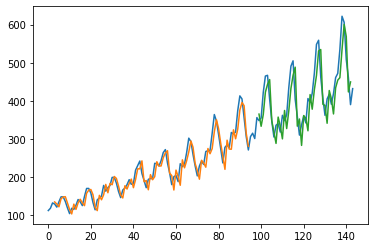

In [23]:
???


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    ???

    return np.array(dataX), np.array(dataY)

# load the dataset
???

# split into train and test sets
???

# reshape dataset
???

# create and fit Multilayer Perceptron model
???

# Estimate model performance
???

# generate predictions for training
???

# shift train predictions for plotting
???

# shift test predictions for plotting
???

# plot baseline and predictions
???


<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>